In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import torch

import SPCI_class as SPCI
from sklearn.model_selection import train_test_split

In [31]:

market_data = yf.download (tickers = "^GSPC", start = "2010-04-01", end = "2024-03-31", interval = "1d") # start="1927-12-30"
market_data["pct_change"] = market_data["Close"].pct_change()
market_data['date_ordinal'] = pd.to_datetime(market_data.index.to_series()).apply(lambda date: date.toordinal())
market_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal
Date,,,,,,,,
2010-04-01,1171.229980,1181.430054,1170.689941,1178.099976,1178.099976,4006870000,NaN,733863
2010-04-05,1178.709961,1187.729980,1178.709961,1187.439941,1187.439941,3881620000,0.007928,733867
2010-04-06,1186.010010,1191.800049,1182.770020,1189.439941,1189.439941,4086180000,0.001684,733868
2010-04-07,1188.229980,1189.599976,1177.250000,1182.449951,1182.449951,5101430000,-0.005877,733869
2010-04-08,1181.750000,1188.550049,1175.119995,1186.439941,1186.439941,4726970000,0.003374,733870


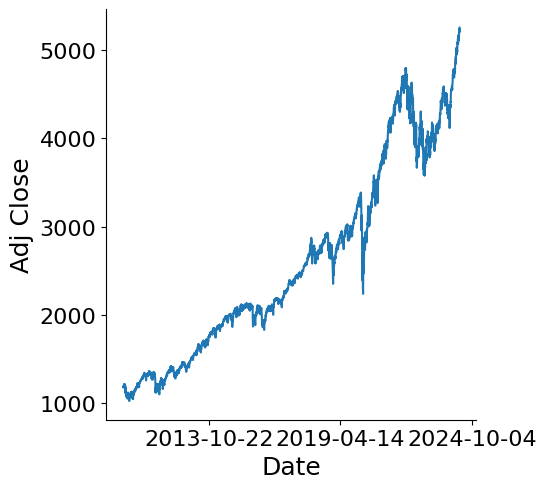

In [32]:
sns.relplot(market_data, x="Date", y="Adj Close", kind="line")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(3))

### To use [SPCI](https://arxiv.org/abs/2212.03463), which performs better (i.e., intervals are narrower) but slower

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For SPCI, larger `past_window` may or may not be better, depending on if there are "shifts" in the data distribution.

In [33]:
# Plot prediction intervals on test sample
def plot_ci(model, x_train, y_train, x_test, y_test, past_window = 30, alpha=0.1):

    SPCI_class_  = SPCI.SPCI_and_EnbPI(
        torch.from_numpy(x_train), 
        torch.from_numpy(x_test), 
        torch.from_numpy(y_train.reshape(-1)), 
        torch.from_numpy(y_test.reshape(-1)), 
        fit_func=model)
    stride = 1
    SPCI_class_.fit_bootstrap_models_online_multistep(
            B = 25, fit_sigmaX=False, stride=stride)

    use_SPCI = True
    smallT = not use_SPCI
    SPCI_class_.compute_PIs_Ensemble_online(alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI, quantile_regr=True, stride=stride)
    results = SPCI_class_.get_results(alpha, 'my_data', 1)

    Pred_ints = SPCI_class_.PIs_Ensemble
#     Y_est = SPCI_class_.Ensemble_pred_interval_centers
#     Y_predict = SPCI_class_.Y_predict.numpy()

    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label=r'$Y$')
    plt.plot(model.predict(x_test), label=r'$\hat{Y}$')
    plt.fill_between(np.arange(len(y_test)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$', color='lightblue')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)
    # plt.xlabel('Test time index')
    plt.ylabel('True $Y$ and prediction')
    # actual_cov = 100*results["coverage"].item()
    # actual_wid = results["width"].item()
    # plt.title(f'Target coverage is {100*(1-alpha):.2f}%. \n Actual coverage is {actual_cov:.2f}% \n Average interval width is {actual_wid:.2f}')

In [34]:
market_data.head()

,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal
Date,,,,,,,,
2010-04-01,1171.229980,1181.430054,1170.689941,1178.099976,1178.099976,4006870000,NaN,733863
2010-04-05,1178.709961,1187.729980,1178.709961,1187.439941,1187.439941,3881620000,0.007928,733867
2010-04-06,1186.010010,1191.800049,1182.770020,1189.439941,1189.439941,4086180000,0.001684,733868
2010-04-07,1188.229980,1189.599976,1177.250000,1182.449951,1182.449951,5101430000,-0.005877,733869
2010-04-08,1181.750000,1188.550049,1175.119995,1186.439941,1186.439941,4726970000,0.003374,733870


In [35]:
market_data['5_day_avg'] = market_data['Adj Close'].rolling(window=5).mean().shift(1)
market_data['30_day_avg']= market_data['Adj Close'].rolling(window=5).mean().shift(1)
market_data['year_avg'] = market_data['Adj Close'].rolling(window=365).mean().shift(1)
market_data['avg_ratio'] = market_data['5_day_avg']/market_data['year_avg']

market_data['5_day_std'] = market_data['Adj Close'].rolling(window=5).std().shift(1)
market_data['year_std'] = market_data['Adj Close'].rolling(window=365).mean().shift(1)
market_data['std_ratio'] = market_data['5_day_std']/market_data['year_std']
market_data.head(20)

,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal,5_day_avg,30_day_avg,year_avg,avg_ratio,5_day_std,year_std,std_ratio
Date,,,,,,,,,,,,,,,
2010-04-01,1171.229980,1181.430054,1170.689941,1178.099976,1178.099976,4006870000,NaN,733863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-05,1178.709961,1187.729980,1178.709961,1187.439941,1187.439941,3881620000,0.007928,733867,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-06,1186.010010,1191.800049,1182.770020,1189.439941,1189.439941,4086180000,0.001684,733868,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-07,1188.229980,1189.599976,1177.250000,1182.449951,1182.449951,5101430000,-0.005877,733869,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-08,1181.750000,1188.550049,1175.119995,1186.439941,1186.439941,4726970000,0.003374,733870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-09,1187.469971,1194.660034,1187.150024,1194.369995,1194.369995,4511570000,0.006684,733871,1184.773950,1184.773950,NaN,NaN,4.516564,NaN,NaN
2010-04-12,1194.939941,1199.199951,1194.709961,1196.479980,1196.479980,4607090000,0.001767,733874,1188.027954,1188.027954,NaN,NaN,4.364540,NaN,NaN
2010-04-13,1195.939941,1199.040039,1188.819946,1197.300049,1197.300049,5403580000,0.000685,733875,1189.835962,1189.835962,NaN,NaN,5.721525,NaN,NaN
2010-04-14,1198.689941,1210.650024,1198.689941,1210.650024,1210.650024,5760040000,0.011150,733876,1191.407983,1191.407983,NaN,NaN,6.598160,NaN,NaN


In [36]:
market_data = market_data.dropna()
print(market_data.shape)
x_train, x_test, y_train, y_test = train_test_split(market_data[['5_day_avg', '30_day_avg', 'year_avg', 'avg_ratio', '5_day_std','year_std', 'std_ratio']], market_data["Adj Close"], test_size=30/market_data.shape[0], shuffle=False)
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(3157, 15)


((3127, 7), (30, 7), (3127, 1), (30, 1))

In [37]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression()

1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.08857989311218262 secs.
Shape of slided residual lists is (30, 3127)
Width at test 0 is 88.31285095214844
Width at test 1 is 98.60663604736328
Width at test 2 is 89.63732147216797
Width at test 3 is 157.74891662597656
Width at test 4 is 98.1754035949707
Width at test 5 is 159.10652542114258
Width at test 6 is 158.6358699798584
Width at test 7 is 129.8076934814453
Width at test 8 is 105.6259765625
Width at test 9 is 89.82734298706055
Width at test 10 is 90.82955169677734
Width at test 11 is 110.40495300292969
Width at test 12 is 104.67279815673828
Width at test 13 is 98.0975341796875
Width at test 14 is 88.08570098876953
Width at test 15 is 109.48422431945801
Width at test 16 is 97.070068359375
Width at test 17 is 90.1563491821289
Width at test 18 is 120.99018859863281
Width at test 19 is 99.2464599609375
Width at test 20 is 91.24083709716797
Width at test 21 is 130.3099136352539
Width at test 22 is 89.81371307373047
Width at te

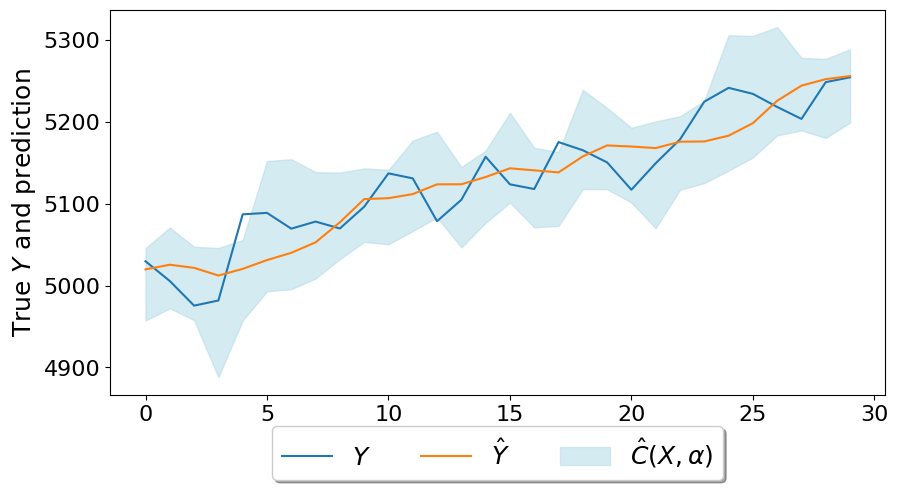

In [38]:
plot_ci(model, x_train, y_train, x_test, y_test, past_window=365, alpha=0.1)

Text(0, 0.5, 'True $Y$ and prediction')

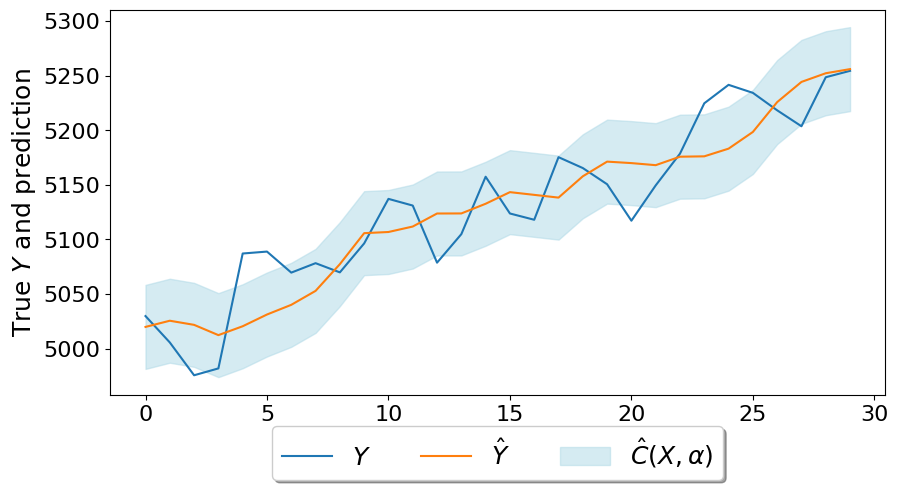

In [39]:
from scipy.stats import t

predictions = model.predict(x_test)

test_length = 30

alpha = 0.1

residuals = y_test - predictions
mse = np.mean(residuals**2)
se = np.sqrt(mse / (test_length - 8))

t_statistic = t.ppf(1 - alpha / 2, test_length - 8)

lower_bound = predictions - t_statistic * se
upper_bound = predictions + t_statistic * se

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test, label=r'$Y$')
plt.plot(predictions, label=r'$\hat{Y}$')
# plt.plot(predictions, color='blue', label='Predictions')
# plt.plot(y_test, color='black', label='Actuals')
plt.fill_between(np.arange(len(y_test)), lower_bound, upper_bound, alpha=0.5, label=r'$\hat{C}(X,\alpha)$', color='lightblue')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)
# plt.xlabel('Dates')
plt.ylabel('True $Y$ and prediction')
# plt.title('Linear Regression Predictions with 90% Confidence Interval')
# plt.legend()
# plt.grid(True)
# plt.show()
